# Burgers (Convection-Diffusion) PDE

In [3]:
import numpy
from matplotlib import pyplot
import sympy

pyplot.style.use('seaborn')

Combination of non-linear convection and diffusion PDEs

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=\nu \frac{\partial^2 u}{\partial x^2}$$

Shorter form: $u_t+u \cdot u_x=\nu \cdot u_{xx}$

Time extrapolation:

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

**Initial condition** is given by these equations:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}

**Boundary condition** is periodic:

$$u(0)=u(2\pi)$$

## Evaluate initial condition

First, we deal with the initial condition, calculating $\frac{\partial \phi}{\partial x}$ then substitute to $u$, all using Sympy (solve analytically).

In [22]:
def initialize_burgers(nx, L, nu):
    # Initialize u in the Burgers PDE
    
    # output sympy results print to Latex
    sympy.init_printing()

    # declare sympy variables
    x, nu, t = sympy.symbols('x nu t')

    # Equation phi
    phi = (sympy.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
           sympy.exp(-(x - 4 * t - 2 * sympy.pi)**2 / (4 * nu * (t + 1))))

    # take derivative of phi to x
    dphi_dx = phi.diff(x)

    # substitute dphi/dx to u
    u = -2 * nu * (dphi_dx / phi) + 4

    # lambdify u (convert u to a function that can be used)
    from sympy.utilities.lambdify import lambdify
    u = lambdify((x, nu, t), u)

    # Parameters for initial condition
    nx = 101  # number of spatial grid points
    L = 2.0 * numpy.pi  # length of the domain
    nu = 0.07  # viscosity

    # Discretize the domain.
    x = numpy.linspace(0.0, L, num=nx)

    # create u0 (initial) from the lambdified function u
    t = 0.0
    u0 = numpy.array([u(xi, nu, t) for xi in x])

    # Plot the initial conditions.
    pyplot.figure(figsize=(6.0, 4.0))
    pyplot.title('Initial conditions')
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, color='C0', linestyle='-', linewidth=2)
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 10.0);

    pyplot.grid()    
    
    return u0

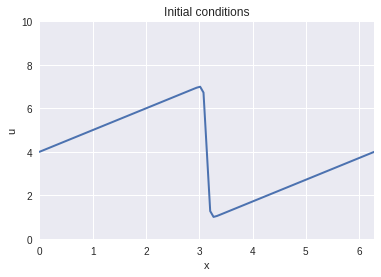

In [23]:
# Set parameters for initial conditions
nx, L, nu = 101, 2 * numpy.pi, 0.07

u0 = initialize_burgers(nx, L, nu)

Make the simulation function `burgers_cfl`. Default CFL `sigma` is 0.1. 

We know that evaluating the initial condition takes longer time (to solve it analytically), therefore to speed up simulation inside the function, `u0` will be inputted into function.

In [39]:
def burgers_cfl(nx, u0, L, nu, cfl, nt):
    # u0 is the initial condition already solved analytically
    
    # compute dx and dt from CFL specified
    dx = L / (nx - 1)    
    dt = sigma * dx**2 / nu  # time-step size  
    
    # Discretize the domain.
    x = numpy.linspace(0.0, L, num=nx)    
    
    # Integrate the Burgers' equation in time.
    u = u0.copy()
    for n in range(nt):
        un = u.copy()
        # Update all interior points.
        u[1:-1] = (un[1:-1] -
                   un[1:-1] * dt / dx * (un[1:-1] - un[:-2]) +
                   nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[:-2]))
        # Update boundary points.
        u[0] = (un[0] -
                un[0] * dt / dx * (un[0] - un[-1]) +
                nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-1]))
        u[-1] = (un[-1] -
                un[-1] * dt / dx * (un[-1] - un[-2]) +
                nu * dt / dx**2 * (un[0] - 2 * un[-1] + un[-2])) 
        
    # Plot the solution along with the initial conditions.
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.legend()
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 10);  
    pyplot.grid()

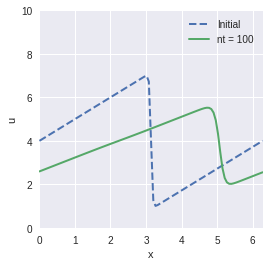

In [40]:
# set additional parameters for simulation
cfl = 0.1
nt = 100

# simulation
burgers_cfl(nx, u0, L, nu, cfl, nt)

See Prof L. Barba's notebook (Module 2 Lesson 4), the numerical and analytical solutions are compared. 

## Producing animation

In [57]:
from matplotlib import animation
from IPython.display import HTML

In [47]:
def burgers_mov(nx, u0, L, nu, cfl, nt):
    # u0 is the initial condition already solved analytically
    
    # compute dx and dt from CFL specified
    dx = L / (nx - 1)    
    dt = sigma * dx**2 / nu  # time-step size  
    
    # Discretize the domain.
    x = numpy.linspace(0.0, L, num=nx)    
    
    # Integrate the Burgers' equation in time.
    u_hist = [u0.copy()]
    u = u0.copy()
    for n in range(nt):
        un = u.copy()
        # Update all interior points.
        u[1:-1] = (un[1:-1] -
                   un[1:-1] * dt / dx * (un[1:-1] - un[:-2]) +
                   nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[:-2]))
        # Update boundary points.
        u[0] = (un[0] -
                un[0] * dt / dx * (un[0] - un[-1]) +
                nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-1]))
        u[-1] = (un[-1] -
                un[-1] * dt / dx * (un[-1] - un[-2]) +
                nu * dt / dx**2 * (un[0] - 2 * un[-1] + un[-2])) 
        u_hist.append(u.copy())
    
    return x, u0, u_hist

In [48]:
x, u0, u_hist = burgers_mov(nx, u0, L, nu, cfl, nt)

In [59]:
def update_plot(n, u_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    u_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(u_hist[n])

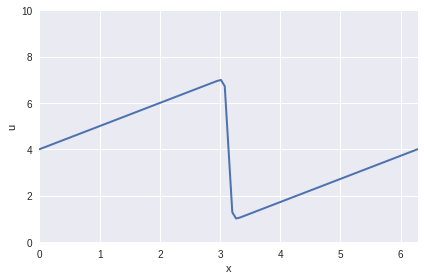

In [55]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
line = pyplot.plot(x, u0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(0, 10)
fig.tight_layout()
pyplot.grid()

In [60]:
# Create an animation.
nt = 100
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(u_hist,),
                               interval=200)

In [61]:
# Display the video.
HTML(anim.to_html5_video())